# Examining Cloud Information in the RRFS Ensemble

shawn.s.murdzek@noaa.gov

Machine: Jet  
Environment: adb_graphics

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml
import metpy.calc as mc
from metpy.units import units
import metpy.constants as const

import pyDA_utils.plot_model_data as pmd
import pyDA_utils.bufr as bufr
import pyDA_utils.ensemble_utils as eu

In [16]:
from importlib import reload
eu = reload(eu)

# Input Parameters

In [2]:
"""
Read Input Parameters
"""

case = 'S_NewEngland_2022020121'
yml_fname = '/lfs4/BMC/wrfruc/murdzek/src/py_scripts/cloud_da/cases/{c}/{c}_input.yml'.format(c=case)
with open(yml_fname, 'r') as fptr:
    param = yaml.safe_load(fptr)

# UPP output for each ensemble member
str_format = param['str_format']
prslev_fnames = {}
natlev_fnames = {}
for i in range(1, param['nmem']+1):
    prslev_fnames['mem{num:04d}'.format(num=i)] = str_format.format(num=i, lev='prslev')
    natlev_fnames['mem{num:04d}'.format(num=i)] = str_format.format(num=i, lev='natlev')
prslev_vars = param['prslev_vars']

# BUFR file name
bufr_fname = param['bufr_fname']

# Subset domain
min_lon = param['min_lon']
max_lon = param['max_lon']
min_lat = param['min_lat']
max_lat = param['max_lat']
z_ind = param['z_ind']

# Variables to include in state matrix (assumed to be 3D)
state_vars = param['state_vars']

# Tag for output files
save_tag = param['save_tag']
out_dir = param['out_dir']

# "Target" (lat, lon) coordinate for BEC spatial plots
do_bec = param['do_bec']
bec_lat = param['bec_lat']
bec_lon = param['bec_lon']
bec_klvl = param['bec_klvl']

# Read in Ensemble and BUFR Output

In [3]:
"""
Read in ensemble output and BUFR obs
"""

ens_obj = eu.ensemble(natlev_fnames, extra_fnames=prslev_fnames, extra_fields=prslev_vars, 
                      bufr_csv_fname=bufr_fname, lat_limits=[min_lat, max_lat], lon_limits=[min_lon, max_lon],
                      zind=z_ind, state_fields=state_vars, bec=do_bec)
print('Shape of subset =', ens_obj.subset_ds['mem0001']['TMP_P0_L105_GLC0'].shape)

reading member mem0001
reading member mem0002
reading member mem0003
reading member mem0004
reading member mem0005
reading member mem0006
reading member mem0007
reading member mem0008
reading member mem0009
reading member mem0010
reading member mem0011
reading member mem0012
reading member mem0013
reading member mem0014
reading member mem0015
reading member mem0016
reading member mem0017
reading member mem0018
reading member mem0019
reading member mem0020
reading member mem0021
reading member mem0022
reading member mem0023
reading member mem0024
reading member mem0025
reading member mem0026
reading member mem0027
reading member mem0028
reading member mem0029
reading member mem0030


/contrib/miniconda3/4.5.12/envs/adb_graphics/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


computing BEC...


/contrib/miniconda3/4.5.12/envs/adb_graphics/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/contrib/miniconda3/4.5.12/envs/adb_graphics/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Shape of subset = (1, 82, 84)


# Plotting Cells

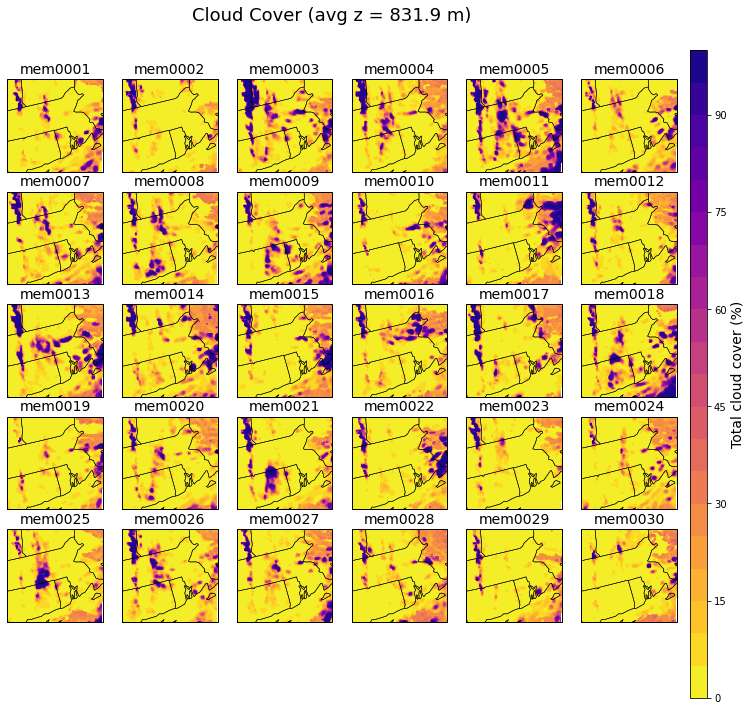

In [4]:
"""
Make horizontal cross section postage stamp plots: Cloud Cover at a Single Vertical Level
"""

# Field name and colorbar limits/colormap. Set klvl to NaN if 2D field
upp_field = 'TCDC_P0_L105_GLC0'
save_fname = '{d}/postage_stamp_cloud_cover_{tag}.png'.format(d=out_dir, tag=save_tag)
title = 'Cloud Cover'
klvl = 0
cmap = 'plasma_r'
clevels = np.arange(0, 100.1, 5)
extend = 'neither'

nrows = 5
ncols = 6
figsize = (12, 10)

###

# Make plot

fig = ens_obj.postage_stamp_contourf(upp_field, nrows, ncols, klvl=klvl, figsize=figsize, title=title,
                                     plt_kw={'ingest_kw':{'zind':[klvl]}, 
                                             'cntf_kw':{'cmap':cmap, 'levels':clevels, 'extend':extend}})

plt.savefig(save_fname)

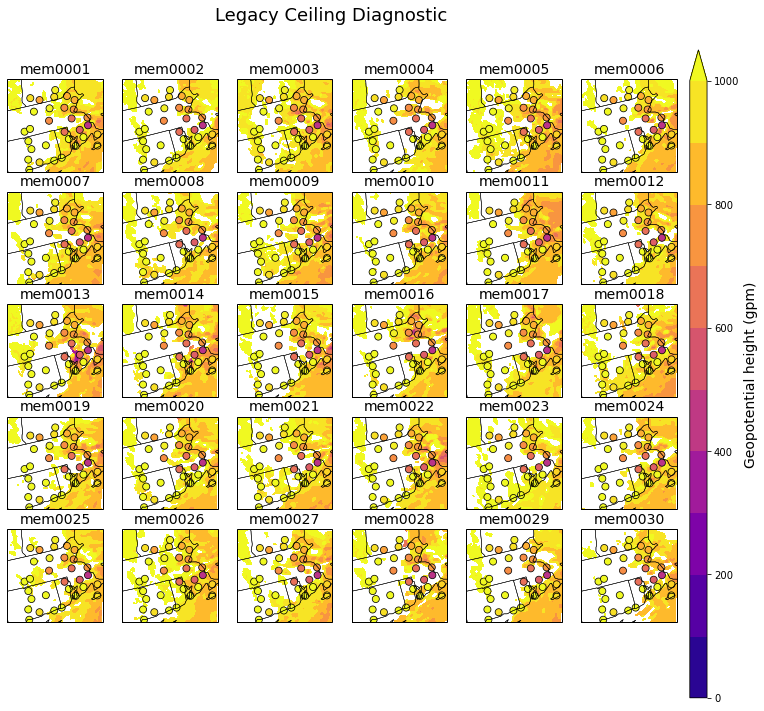

In [5]:
"""
Make horizontal cross section postage stamp plots: Ceilings (with BUFR obs)
"""

# Field name and colorbar limits/colormap. Set klvl to NaN if 2D field
upp_field = 'HGT_P0_L215_GLC0'
save_fname = '{d}/postage_stamp_ceil_{tag}.png'.format(d=out_dir, tag=save_tag)
title = 'Legacy Ceiling Diagnostic'
klvl = np.nan
cmap = 'plasma'
clevels = np.arange(0, 1000.1, 100)
extend = 'max'

bufr_field = 'CEILING'
bufr_subset = ['ADPSFC']
bufr_nonan = 'TOB'     # Only use a row if this obs is not NaN

nrows = 5
ncols = 6
figsize = (12, 10)

###

# Make plot

fig = ens_obj.postage_stamp_contourf(upp_field, nrows, ncols, klvl=klvl, figsize=figsize, title=title,
                                     plt_kw={'ingest_kw':{'zind':[klvl]}, 
                                             'cntf_kw':{'cmap':cmap, 'levels':clevels, 'extend':extend}})
ens_obj.plot_bufr_obs(fig.get_axes()[:-1], bufr_field, bufr_subset, bufr_nonan, 
                      scatter_kw={'cmap':cmap, 'vmin':clevels[0], 'vmax':clevels[-1], 
                                  'edgecolors':'k', 'linewidths':0.75, 's':50})

plt.savefig(save_fname)

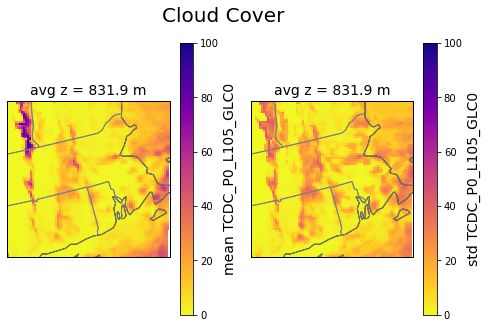

In [6]:
"""
Plot Ensemble Mean and Standard Deviation
"""

# Field name and colorbar limits/colormap. Set klvl to NaN if 2D field
upp_field = 'TCDC_P0_L105_GLC0'
save_fname = '{d}/ens_mean_std_{tag}.png'.format(d=out_dir, tag=save_tag)
title = 'Cloud Cover'
klvl = 0
cmap = 'plasma_r'
vmin = 0
vmax = 100
extend = 'neither'

nrows = 1
ncols = 2
figsize = (8, 5)

###

# Make plot
fig = plt.figure(figsize=figsize)
for i, stat in enumerate(['mean', 'std']):
    ax = ens_obj.plot_state_vector(stat, upp_field, fig, nrows, ncols, i+1, zind=klvl, 
                                   pcm_kw={'cmap':cmap, 'vmin':vmin, 'vmax':vmax})


plt.suptitle(title, size=20)
plt.savefig(save_fname)

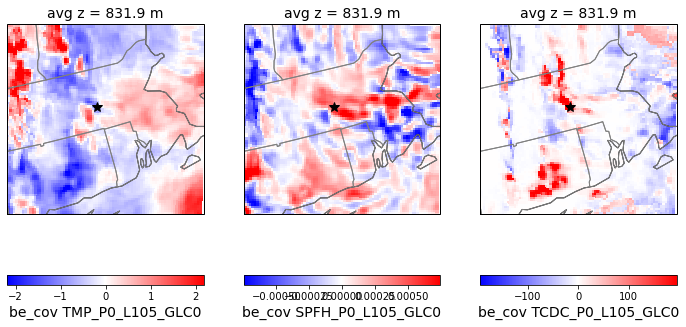

In [7]:
"""
Plot Spatial Distributions of BECs For a Particular Gridpoint and Variable
"""

# Coordinate of point to plot BECs in relation to (this is the "target" point)
var = 'TCDC_P0_L105_GLC0'
plot_klvl = bec_klvl
save_fname = '{d}/BEC_spatial_dist_{tag}.png'.format(d=out_dir, tag=save_tag)

###

if do_bec:

    # Determine gridpoint closest to the target (lat, lon) coordinate
    tmp_ds = ens_obj.subset_ds[ens_obj.mem_names[0]]
    lat_all = tmp_ds['gridlat_0'].values
    lon_all = tmp_ds['gridlon_0'].values
    target_i, target_j = np.unravel_index(np.argmin((lat_all - bec_lat)**2 + (lon_all - bec_lon)**2), lon_all.shape)

    # Determine indices corresponding with the target variable and location
    target_var_idx = np.where(ens_obj.state_matrix['vars'] == var)[0]
    target_idx = target_var_idx[0] + np.ravel_multi_index([[bec_klvl], [target_i], [target_j]], 
                                                          tmp_ds[var].shape)

    # Make plot
    fig = plt.figure(figsize=(12, 7.5))
    for i, v in enumerate(state_vars):
        ax = ens_obj.plot_state_vector('be_cov', v, fig, 1, len(state_vars), i+1, zind=plot_klvl,
                                       bec_idx=target_idx, ctr_cmap_0=True,
                                       pcm_kw={'cmap':'bwr', 'vmin':vmin, 'vmax':vmax},
                                       cbar_kw={'orientation':'horizontal'})
        ax.plot(lon_all[target_i, target_j], lat_all[target_i, target_j], 'k*', ms=10, transform=ccrs.PlateCarree())

    plt.savefig(save_fname)

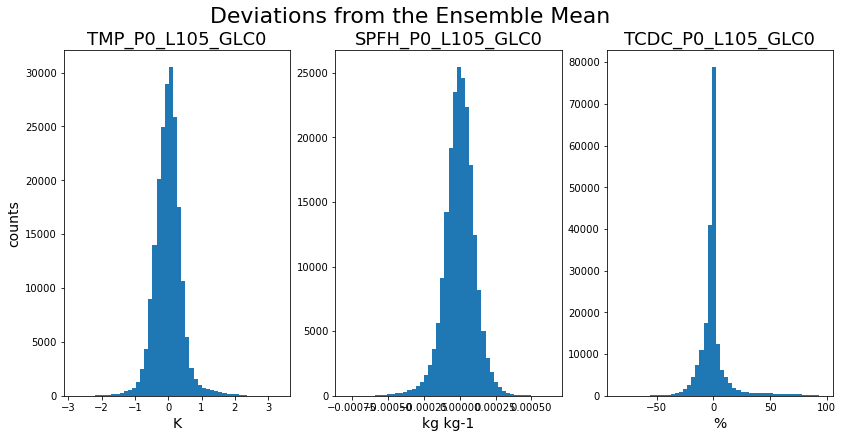

In [8]:
"""
Plot Histograms of Deviations from Ensemble Mean
"""

save_fname = '{d}/error_hist_{tag}.png'.format(d=out_dir, tag=save_tag)

###

fig, axes = plt.subplots(nrows=1, ncols=len(state_vars), figsize=(12, 6))
plt.subplots_adjust(left=0.1, bottom=0.08, right=0.99, top=0.88, wspace=0.2)
for i, v in enumerate(state_vars):
    axes[i] = ens_obj.plot_ens_dev_hist(v, axes[i], hist_kw={'bins':50})

axes[0].set_ylabel('counts', size=14)
plt.suptitle('Deviations from the Ensemble Mean', size=22)
plt.savefig(save_fname)

making plot


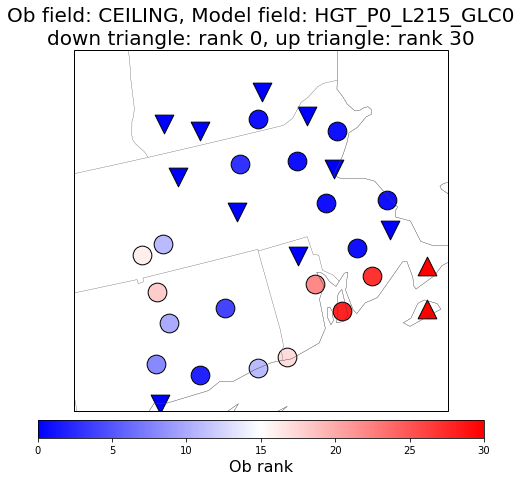

In [9]:
"""
Plot Rank For Each Ceiling Ob
"""

model_field = 'HGT_P0_L215_GLC0'
klvl = np.nan
save_fname = '{d}/ceiling_ranks_{tag}.png'.format(d=out_dir, tag=save_tag)

bufr_field = 'CEILING'
bufr_subset = ['ADPSFC']
bufr_nonan = 'TOB'     # Only use a row if this ob is not NaN

###

# Interpolate ensemble members to ob locations
subset_obs = ens_obj._subset_bufr(bufr_subset, bufr_nonan)
ens_interp = ens_obj.interp_model_2d(model_field, subset_obs['YOB'].values, subset_obs['XOB'].values-360., 
                                     zind=klvl, method='nearest')

# Determine ranks
ranks = np.zeros(len(subset_obs))
ob_vals = subset_obs[bufr_field].values
ens_vals = mc.geopotential_to_height(ens_interp.loc[:, ens_obj.mem_names].values * units.m * const.g).to('m').magnitude
for i in range(len(ranks)):
    ranks[i] = np.sum(ob_vals[i] > ens_vals[i, :])

# Change NaNs to be an arbitrarily large number
ob_vals[np.isnan(ob_vals)] = 1e8
ens_vals[np.isnan(ens_vals)] = 1e9
    
# Plot ranks
print('making plot')
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
for i in range(len(ranks)):
    if ranks[i] == 0:
        m = 'v'
    elif ranks[i] == param['nmem']:
        m = '^'
    else:
        m = 'o'
    cax = ax.scatter(subset_obs.loc[i, 'XOB'], subset_obs.loc[i, 'YOB'], c=ranks[i], 
                     s=350, cmap='bwr', vmin=0, vmax=param['nmem'], marker=m, linewidths=1, edgecolors='k',
                     transform=ccrs.PlateCarree(), alpha=1)
    
ax.set_title('Ob field: {ob_f}, Model field: {m_f}\n'.format(ob_f=bufr_field, m_f=model_field) +
             'down triangle: rank 0, up triangle: rank {rmax}'.format(rmax=param['nmem']), size=20)
ax.set_extent([min_lon, max_lon, min_lat, max_lat])
ax.coastlines('50m', edgecolor='gray', linewidth=0.25)
borders = cfeature.NaturalEarthFeature(category='cultural',
                                        scale='50m',
                                       facecolor='none',
                                       name='admin_1_states_provinces')
ax.add_feature(borders, linewidth=0.25, edgecolor='gray')
#lakes = cfeature.NaturalEarthFeature(category='physical',
#                                     scale='50m',
#                                     facecolor='none',
#                                     name='lakes')
#ax.add_feature(lakes, linewidth=0.25, edgecolor='gray')

cbar = plt.colorbar(cax, ax=ax, orientation='horizontal', pad=0.02, aspect=25)
cbar.set_label('Ob rank', size=16)
plt.savefig(save_fname)

In [10]:
np.mean(ens_obj.ds['mem0001']['HGT_P0_L105_GLC0'][17, :, :] - ens_obj.ds['mem0001']['HGT_P0_L1_GLC0'])

<xarray.DataArray ()>
array(971.7851, dtype=float32)
Coordinates:
    lv_HYBL2  float32 18.0